In [1]:
from tqdm import tqdm
import numpy as np
import os
import random
import glob
import re
import random

import cv2
import geopandas as gpd
import pandas as pd

import albumentations as A

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
import segmentation_models_pytorch as smp
from torchvision.utils import make_grid, save_image

from sklearn.model_selection import train_test_split

import model
import metrics
import config
import utis
import train

from matplotlib import pyplot as plt, cm

from torch.utils.data import DataLoader, random_split
from dataset import HistoricalImagesDataset
import config

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

# WandB – Import the wandb library
import wandb

import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

In [2]:
# Paths
IMAGES_PATH = '../data/patches/images/1942'
MASK_PATH = '../data/patches/masks/1942'
BEST_MODEL = '../best_model'
FILTER_PATH = '../data/geopackages/patch_keys.gpkg'
# PREDICTIONS_PATH = 

image_paths = glob.glob(IMAGES_PATH +'/*.tif')
mask_paths = glob.glob(MASK_PATH +'/*.tif')


### Weights and Biases

In [3]:
!wandb login

wandb: Currently logged in as: vibferreira (use `wandb login --relogin` to force relogin)


### Selection of non-noisy dataset

In [4]:
def remove_paths_with_more_than_one_class(mask_paths:list, image_paths:list):
    i = 0
    for mask, img in zip(mask_paths,image_paths):
        data = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        if len(np.unique(data)) > 1:
            image_paths.remove(img)
            mask_paths.remove(mask)
            i+=1
    print(f'{i} paths removed')
    return image_paths, mask_paths
# remove_paths_with_more_than_one_class(veg_mask_paths, veg_image_paths)

In [5]:
# Read file 
geo_df = gpd.read_file(FILTER_PATH) # contains the idx of the non-noisy data

# Define the filters 
dic = {'non_veg_idxs' : geo_df.query("status == 0")['index'],
       'veg_idxs' : geo_df.query("status == 1")['index'], 
       'mixed': geo_df.query("status == 2")['index'], 
       'single_trees_idx' : geo_df.query("status == 3")['index'], 
       'hedgerows' : geo_df.query("status == 4")['index']}

# sample to the same size of the smallest dataset
sample_size = min([len(value) for key, value in dic.items()])
new_dic = {key:value.sample(n=sample_size, replace=False) for key, value in dic.items()} #random sample

# select a percentage of idxs from each dataset to train, val and test
test_idx = {key:value.sample(n=int(sample_size*0.1), replace=False, random_state=42) for key, value in new_dic.items()}
val_idx =  {key:value.sample(n=int(sample_size*0.1), replace=False, random_state= 0) for key, value in new_dic.items()}
train_idx = {key:value.sample(n=int(sample_size*0.80), replace=False, random_state= 1) for key, value in new_dic.items()}

# Filter the patches accordigngly 
train_images = np.concatenate([utis.filtered_paths(image_paths, value) for key, value in train_idx.items()])
train_masks = np.concatenate([utis.filtered_paths(mask_paths, value) for key, value in train_idx.items()])

val_images = np.concatenate([utis.filtered_paths(image_paths, value) for key, value in val_idx.items()])
val_masks = np.concatenate([utis.filtered_paths(mask_paths, value) for key, value in val_idx.items()])

test_images = np.concatenate([utis.filtered_paths(image_paths, value) for key, value in test_idx.items()])
test_masks = np.concatenate([utis.filtered_paths(mask_paths, value) for key, value in test_idx.items()])

### Dataloader

In [6]:
# shuffle the list - COME UP WITH A SPATIAL SPLIT
X_train, X_test, y_train, y_test = train_test_split(image_paths, mask_paths, test_size=0.30, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42, shuffle=True)

# Define transformations
val_transform = A.Compose(
    [A.Normalize(mean=(0.512), std=(0.167)),
    ToTensorV2()])

train_transform = A.Compose([
      A.Rotate(limit=40,p=0.9, border_mode=cv2.BORDER_CONSTANT), # p stands for the probability with which the transformations are applied
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5), 
      A.Transpose(p=0.5),
      # A.CLAHE(p=0.8),
      A.Normalize(mean=(0.512), std=(0.167)),
      ToTensorV2()])

# Datasets
# train_dataset = HistoricalImagesDataset(train_images, train_masks, transform=train_transform)
# val_dataset = HistoricalImagesDataset(val_images, val_masks, transform=val_transform)
# test_dataset = HistoricalImagesDataset(test_images, test_masks, transform=val_transform)

train_dataset = HistoricalImagesDataset(X_train, y_train, transform=train_transform)
val_dataset = HistoricalImagesDataset(X_val, y_val, transform=val_transform)
test_dataset = HistoricalImagesDataset(X_test[3:], y_test[3:], transform=val_transform)


data = next(iter(train_dataset))
print('shape train image', data[0].shape, 'shape train mask', data[1].shape) 

# Dataloader
print("Training set size: ", len(train_dataset))
train_dataloader = DataLoader(dataset=train_dataset, batch_size = config.BATCH_SIZE, shuffle=True)
print("Validation set size: ", len(val_dataset))
val_dataloader = DataLoader(dataset=val_dataset, batch_size = config.BATCH_SIZE, shuffle=True)

print("Testing set size: ", len(test_dataset))
test_dataloader = DataLoader(dataset=test_dataset, batch_size = config.BATCH_SIZE)

shape train image torch.Size([1, 256, 256]) shape train mask torch.Size([256, 256])
Training set size:  2438
Validation set size:  523
Testing set size:  520


In [7]:
# plt.Figure()
# data = next(iter(test_dataset))

# plt.imshow(data[0].permute(1,2,0))
# plt.imshow(data[1])

In [8]:
val_dataloader_iter = iter(val_dataloader)
# grids = utis.create_segement_grids(val_dataloader_iter)
# utis.plot_grids(grids)

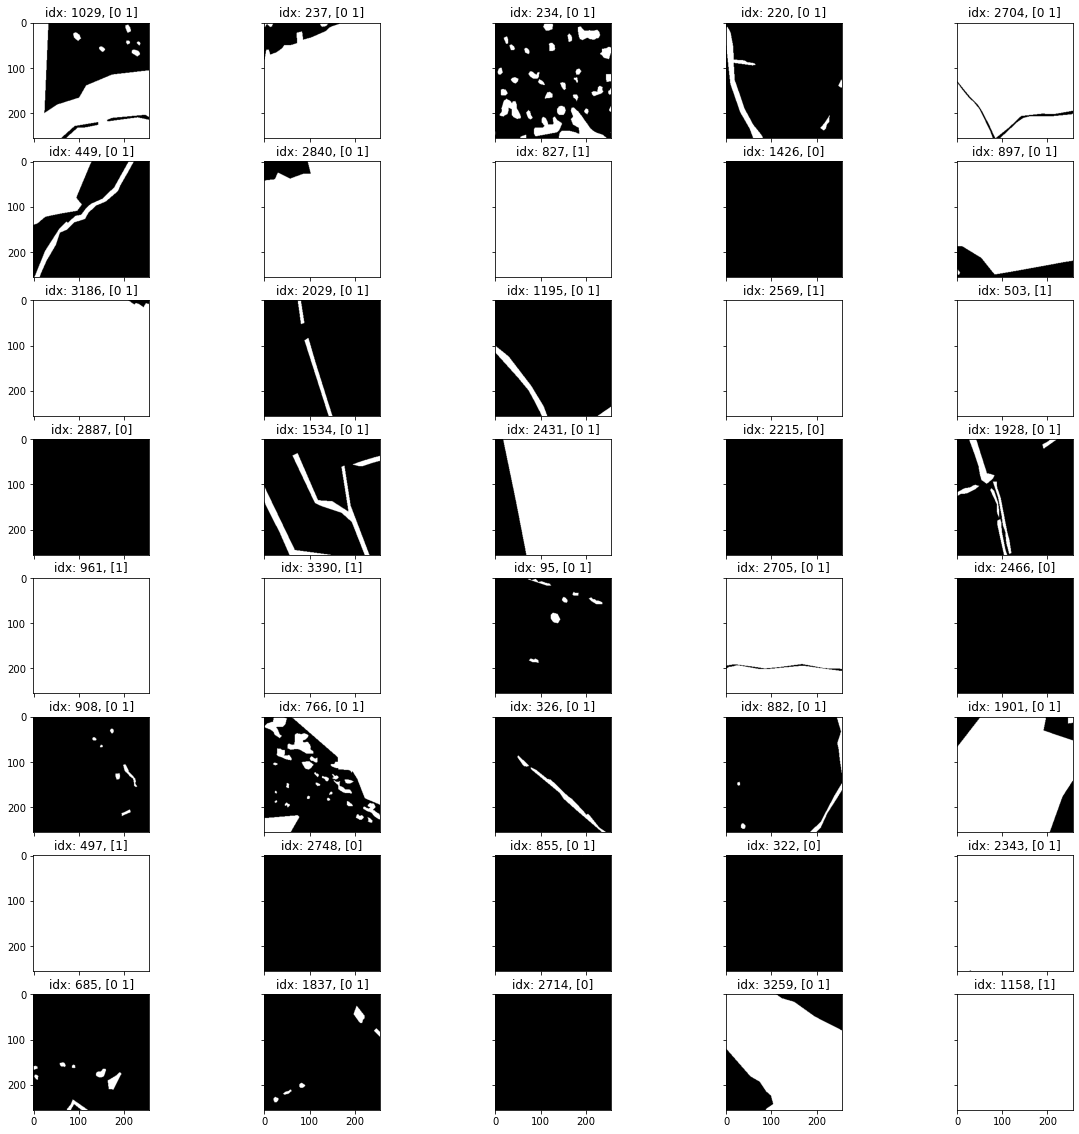

In [9]:
# Plot
n_row = 8
n_col = 5
_, axs = plt.subplots(n_row, n_col, figsize=(20,20), sharex=True, sharey=True)
axs = axs.flatten()
cmap = cm.get_cmap('gray')
random.Random(4).shuffle(test_masks)
random.Random(4).shuffle(test_images)

for i, ax in zip(test_masks, axs):
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    ax.imshow(img, cmap=cmap, vmin=0)
    ax.set_title(f'idx: {utis.get_file_index(i)}, {np.unique(img)}')
plt.show()

### Check if CUDA is available

In [10]:
config.DEVICE

'cuda'

### Training

In [11]:
def train(model, dataloader, optim, lossFunc, epoch, scaler):
    # set the model in training mode
    model.train()

    # Save total train loss
    totalTrainLoss = 0
    
    # metrics
    accuracy = 0
    iou = 0
    f1score = 0
    dice = 0
    
    # loop over the training set
    loop = tqdm(dataloader, leave=False)
    for x, y in loop:
        # send the input to the device
        (x, y) = (x.to(config.DEVICE), y.float().to(config.DEVICE))
        
        # forward with autocast        
        with autocast():
            pred = model(x)
            loss = lossFunc(pred, y)
            
        optim.zero_grad()  # zero out any previously accumulated gradients    
        scaler.scale(loss).backward() # study this 
        scaler.step(optim)
        scaler.update()
        
#         # perform a forward pass and calculate the training loss
#         pred = model(x)
#         loss = lossFunc(pred, y)
        
#         opt.zero_grad()  # zero out any previously accumulated gradients
#         loss.backward() # obtain the gradients with respect to the loss
#         opt.step() # perform one step of gradient descendent
        
        totalTrainLoss += loss  # add the loss to the total training loss so far 
        
        # metrics      
        all_metrics = metrics.metrics(pred, y)
        accuracy += all_metrics['acc']
        iou += all_metrics['iou']
        f1score += all_metrics['f1score']
        dice += all_metrics['dice_coeff']
        
        # update tqdm
        loop.set_description(f'Training Epoch [{epoch}/{config.NUM_EPOCHS}]')
        loop.set_postfix(loss=loss.item(), acc = all_metrics['acc'], iou=all_metrics['iou'], dice = all_metrics['dice_coeff'])
        
    # calculate the average training loss PER EPOCH
    avgTrainLoss = totalTrainLoss / len(dataloader)
    avgAccLoss = accuracy / len(dataloader)
    avgIOU = iou / len(dataloader)
    avgF1score = f1score / len(dataloader)
    avgDice = dice / len(dataloader)
    
    ## update training history
    training_history["avg_train_loss"].append(avgTrainLoss.cpu().detach().numpy()) # save the avg loss
    training_history["train_accuracy"].append(avgAccLoss) # save the acc 
    
    # WANDB
    wandb.log({
    # "Examples": example_images,
    "Train Loss": avgTrainLoss,
    "Train Accuracy": avgAccLoss,
    "IoU_train":avgIOU})
    
    return training_history

In [12]:
def validation(model, dataloader, lossFunc, epoch):
    
    # set the model in evaluation mode
    model.eval()
    # Save total train loss
    totalValLoss = 0
    
    # metrics
    accuracy_val = 0
    iou_val = 0
    f1score_val = 0
    
    # switch off autograd
    example_pred = []
    example_gt = []
    
    with torch.no_grad():
        # loop over the validation set
        loop = tqdm(dataloader, leave=False)
        
        for batch_idx, (x_val, y_val) in enumerate(loop):
            # send the input to the device
            (x_val, y_val) = (x_val.to(config.DEVICE), y_val.to(config.DEVICE))
            
            # make the predictions and calculate the validation loss
            pred_val = model(x_val)
            loss = lossFunc(pred_val, y_val)
            totalValLoss += loss
            
            # metrics      
            all_metrics = metrics.metrics(pred_val, y_val)
            accuracy_val += all_metrics['acc']
            iou_val += all_metrics['iou']
            f1score_val += all_metrics['f1score']
            
            # # Plotting Val 
            # if iter_  % 2 == 0: # plot every time iter is a multiple of 2
            # utis.plot_comparison(x_val, pred_val, y_val)
            # iter_ + 1

            # WandB – Log images in your test dataset automatically, along with predicted and true labels by passing pytorch tensors with image data into wandb.Image
            example_pred.append(wandb.Image(pred_val[0], caption=f"pred_iter_n_{batch_idx}"))
            # print(y_val.shape)
            example_gt.append(wandb.Image(y_val[0].float(), caption=f"gt_iter_n_{batch_idx}"))
            
            # update tqdm
            loop.set_description(f'Validation Epoch [{epoch}/{config.NUM_EPOCHS}]')
            loop.set_postfix(loss_val=loss.item(), acc_val = all_metrics['acc'], iou_val=all_metrics['iou'])
                        
    # calculate the average VALIDATION loss PER EPOCH
    avgValLoss = totalValLoss / len(dataloader)
    avgAccLoss = accuracy_val / len(dataloader)
    avgIOU = iou_val / len(dataloader)
    avgF1score = f1score_val / len(dataloader)

    ## update VALIDATION history
    validation_history["avg_val_loss"].append(avgValLoss.cpu().detach().numpy()) # save the avg loss
    validation_history["val_accuracy"].append(avgAccLoss) # save the acc
    validation_history["IoU_val"].append(avgIOU) # save the acc
    
    # WANDB
    wandb.log({
    "Predictions": example_pred,
    "GT": example_gt,
    "Val Accuracy": avgAccLoss,
    "Val Loss": avgValLoss,
    "IoU_val": avgIOU})
    
    return validation_history

### MAIN

In [13]:
# WandB – Initialize a new run
wandb.init(entity="vibferreira", project="master_thesis")

# classes
classes = ('no_vegetation', 'vegetation')

# Initialize model
unet = model.unet_model.to(config.DEVICE)

# initialize loss function and optimizer
lossFunc = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
opt = optim.Adam(unet.parameters(), lr=config.LR)

# initialize a dictionary to store TRAINING history (keep track on training)
training_history = {"avg_train_loss": [], "train_accuracy": [], "IoU":[],"f1score":[], "avgDice":[]}

# # initialize a dictionary to store VALIDATION history (keep track on VALIDATION)
validation_history = {"avg_val_loss": [], "val_accuracy": [], "IoU_val":[], "f1score_val":[]}

# Using log="all" log histograms of parameter values in addition to gradients
wandb.watch(unet, log="all")

# Autocasting 
scaler = GradScaler()

# initialize best accuracy
best_accuracy = 0.0
print(f'''Training the network for {config.NUM_EPOCHS} epochs, with a batch size of {config.BATCH_SIZE}''') # try with logger

# loop = tqdm(range(config.NUM_EPOCHS))
iter_ = 0
for e in range(config.NUM_EPOCHS):
    trained = train(unet, train_dataloader, opt, lossFunc, epoch=e, scaler=scaler)
    validated = validation(unet, val_dataloader, lossFunc, epoch=e)
    
    # Save best model
    if validated['IoU_val'][-1] > best_accuracy and e > 10: # maybe add a minimum number of epochs as conditions
        utis.save_best_model(unet, BEST_MODEL, validated, e)
        best_accuracy = validation_history['IoU_val'][-1]

wandb: Currently logged in as: vibferreira (use `wandb login --relogin` to force relogin)


Training the network for 150 epochs, with a batch size of 8


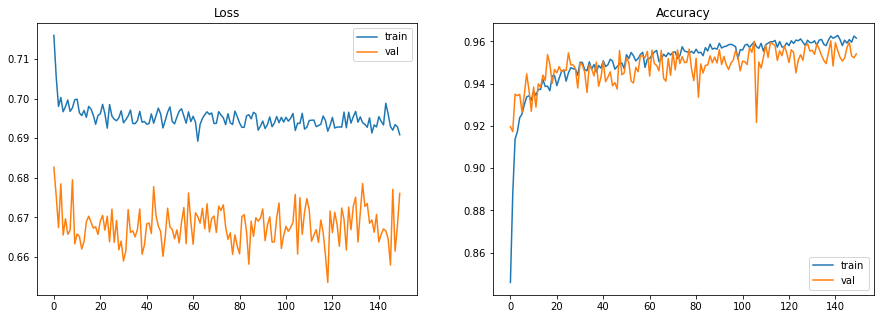

In [14]:
_, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(training_history['avg_train_loss'], label= 'train')
ax[0].plot(validation_history['avg_val_loss'], label='val')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(training_history['train_accuracy'], label= 'train')
ax[1].plot(validation_history['val_accuracy'], label='val')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

### Predictions

In [15]:
def make_predictions(model, 
                     dataloader) -> list:
    model.eval()

    # Save total train loss
    totalValLoss = 0

    # log the predictions to WANDB
    example_pred = []
    example_gt = []

    # save the predicons and the targets
    y_hat_test = []
    y_true_test = []

    # switch off autograd
    with torch.no_grad():
        # loop over the validation set
        loop = tqdm(dataloader, leave=False)

        for batch_idx, (x_test, y_test) in enumerate(loop):
            # send the input to the device
            (x_test, y_test) = (x_test.to(config.DEVICE), y_test.to(config.DEVICE))

            # predictions
            pred_test = model(x_test)

            # Assign appropriate class 
            pred_test_class = (pred_test > 0.5).detach().float() # last layer is already sigmoid

            # Storing predictions and true labels 
            y_hat_test.append(pred_test_class.cpu().view(-1, ))
            y_true_test.append(y_test.cpu().view(-1, ).float())

            # # Plotting test
 
            plot_comparison(x_test, pred_test_class, y_test)

            # # WandB – Log images in your test dataset automatically, along with predicted and true labels by passing pytorch tensors with image data into wandb.Image
            example_pred.append(wandb.Image(pred_test[0], caption=f"pred_iter_n_{batch_idx}"))
            example_gt.append(wandb.Image(y_test[0].float(), caption=f"gt_iter_n_{batch_idx}"))

            # update tqdm
            loop.set_description(f'Testing Epoch')
            
            # Save images
            # print(f'Saving {pred_{idx}.png}')
            # save_image(pred_test, f"{folder}/pred_{idx}.png") 
            # save_image(y_test, f"{folder}/y_true_{idx}.png")

        # WANDB
        wandb.log({
        "Predictions": example_pred,
        "GT": example_gt})

        # Stack and flatten for confusion matrix # GETTING SIZE ERROR AT THE MOMENT
        y_hat_stack = torch.stack(y_hat_test)
        y_true_stack = torch.stack(y_true_test)
        
        return y_hat_stack, y_true_stack

In [16]:
def plot_comparison(x:torch.Tensor, 
                    pred:torch.Tensor, 
                    y:torch.Tensor) -> None:
    
    # print(y.shape, pred.shape, x.shape)
    
    gt = np.squeeze(y.data.cpu().cpu().numpy()[4])
    pred = np.squeeze(pred.sigmoid().cpu().numpy()[4])
    img = np.squeeze(x.data.cpu().cpu().numpy()[4])
    _, ax = plt.subplots(1, 3, sharey='row')
    
    print(y.shape[0])
    
     # Assign appropriate class 
    pred = (pred > 0.5)
    
    plt.figure()
    cmap = cm.get_cmap('gray') # define color map
    plt.gray()
    ax[0].imshow(img)
    ax[0].set_title('Image')

    ax[1].imshow(gt, cmap=cmap, vmin=0) # 0 are balck and white are 1  
    # ax[1].imshow(gt, cmap=cmap, vmin=0) # 
    ax[1].set_title('Ground Truth')

    ax[2].imshow(pred, cmap=cmap, vmin=0)
    ax[2].set_title(f'Prediction')
    plt.show()

wandb: ERROR Control-C detected -- Run data was not synced


  0%|                                                                                                                 | 0/65 [00:00<?, ?it/s]

8


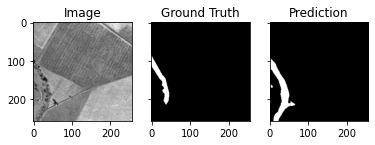

<Figure size 432x288 with 0 Axes>

Testing Epoch:   2%|█▍                                                                                        | 1/65 [00:00<00:20,  3.12it/s]

8


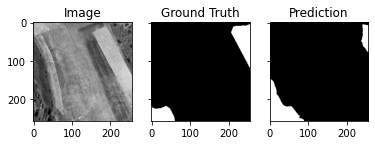

<Figure size 432x288 with 0 Axes>

Testing Epoch:   3%|██▊                                                                                       | 2/65 [00:00<00:19,  3.31it/s]

8


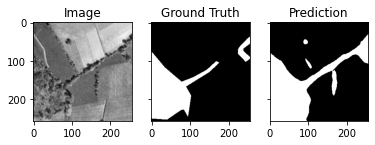

<Figure size 432x288 with 0 Axes>

Testing Epoch:   5%|████▏                                                                                     | 3/65 [00:00<00:18,  3.36it/s]

8


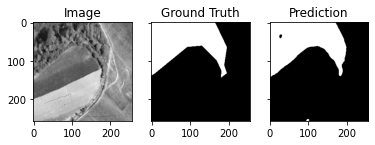

<Figure size 432x288 with 0 Axes>

Testing Epoch:   6%|█████▌                                                                                    | 4/65 [00:01<00:17,  3.43it/s]

8


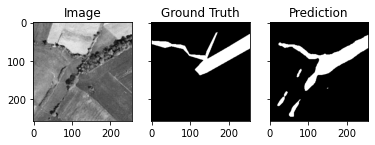

<Figure size 432x288 with 0 Axes>

Testing Epoch:   8%|██████▉                                                                                   | 5/65 [00:01<00:17,  3.52it/s]

8


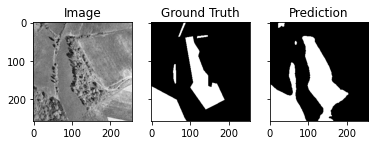

<Figure size 432x288 with 0 Axes>

Testing Epoch:   9%|████████▎                                                                                 | 6/65 [00:01<00:17,  3.36it/s]

8


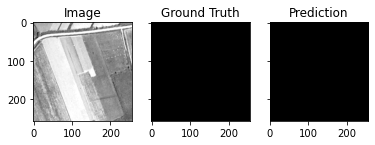

<Figure size 432x288 with 0 Axes>

Testing Epoch:  11%|█████████▋                                                                                | 7/65 [00:02<00:16,  3.42it/s]

8


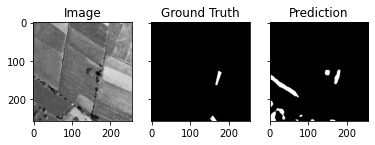

<Figure size 432x288 with 0 Axes>

Testing Epoch:  12%|███████████                                                                               | 8/65 [00:02<00:16,  3.36it/s]

8


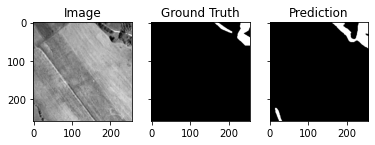

<Figure size 432x288 with 0 Axes>

Testing Epoch:  14%|████████████▍                                                                             | 9/65 [00:02<00:16,  3.35it/s]

8


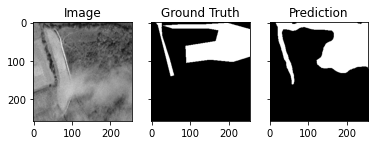

<Figure size 432x288 with 0 Axes>

Testing Epoch:  15%|█████████████▋                                                                           | 10/65 [00:03<00:16,  3.24it/s]

8


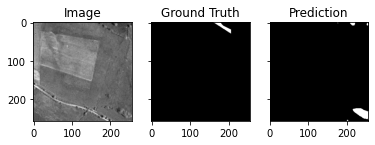

<Figure size 432x288 with 0 Axes>

Testing Epoch:  17%|███████████████                                                                          | 11/65 [00:03<00:21,  2.57it/s]

8


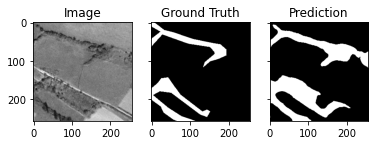

<Figure size 432x288 with 0 Axes>

Testing Epoch:  18%|████████████████▍                                                                        | 12/65 [00:03<00:18,  2.86it/s]

8


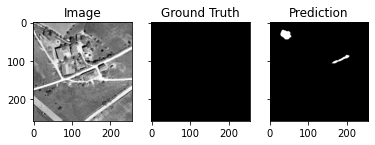

<Figure size 432x288 with 0 Axes>

Testing Epoch:  20%|█████████████████▊                                                                       | 13/65 [00:04<00:17,  3.04it/s]

8


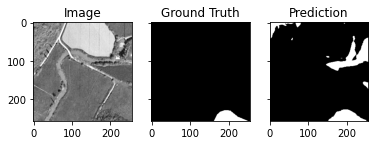

<Figure size 432x288 with 0 Axes>

Testing Epoch:  22%|███████████████████▏                                                                     | 14/65 [00:04<00:15,  3.21it/s]

8


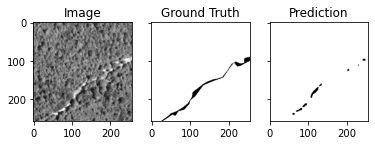

<Figure size 432x288 with 0 Axes>

Testing Epoch:  23%|████████████████████▌                                                                    | 15/65 [00:04<00:14,  3.47it/s]

8


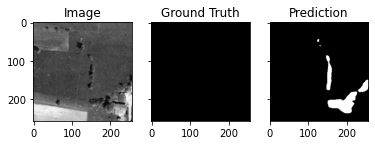

<Figure size 432x288 with 0 Axes>

Testing Epoch:  25%|█████████████████████▉                                                                   | 16/65 [00:04<00:13,  3.75it/s]

8


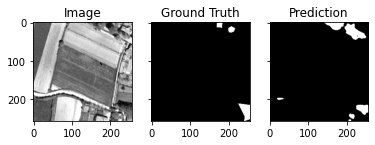

<Figure size 432x288 with 0 Axes>

Testing Epoch:  26%|███████████████████████▎                                                                 | 17/65 [00:05<00:12,  3.84it/s]

8


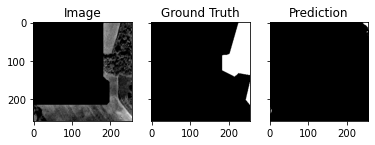

<Figure size 432x288 with 0 Axes>

Testing Epoch:  28%|████████████████████████▋                                                                | 18/65 [00:05<00:12,  3.87it/s]

8


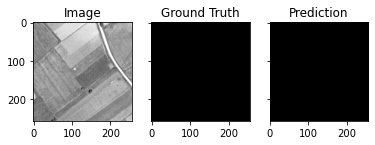

<Figure size 432x288 with 0 Axes>

Testing Epoch:  29%|██████████████████████████                                                               | 19/65 [00:05<00:11,  3.86it/s]

8


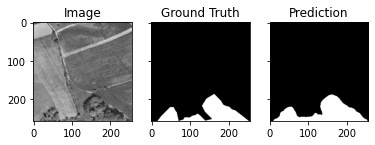

<Figure size 432x288 with 0 Axes>

Testing Epoch:  31%|███████████████████████████▍                                                             | 20/65 [00:05<00:11,  3.77it/s]

8


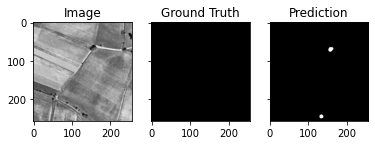

<Figure size 432x288 with 0 Axes>

Testing Epoch:  32%|████████████████████████████▊                                                            | 21/65 [00:06<00:11,  3.71it/s]

8


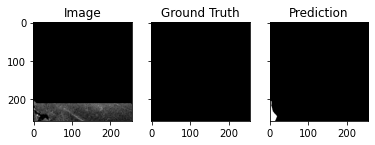

<Figure size 432x288 with 0 Axes>

Testing Epoch:  34%|██████████████████████████████                                                           | 22/65 [00:06<00:11,  3.84it/s]

8


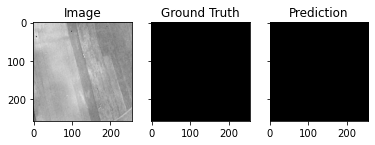

<Figure size 432x288 with 0 Axes>

Testing Epoch:  35%|███████████████████████████████▍                                                         | 23/65 [00:06<00:10,  4.02it/s]

8


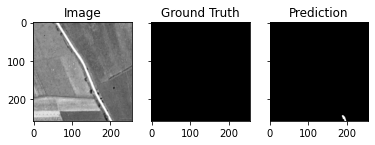

<Figure size 432x288 with 0 Axes>

Testing Epoch:  37%|████████████████████████████████▊                                                        | 24/65 [00:07<00:12,  3.21it/s]

8


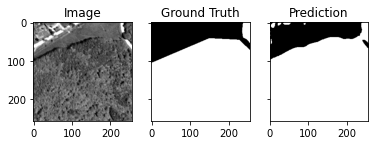

<Figure size 432x288 with 0 Axes>

Testing Epoch:  38%|██████████████████████████████████▏                                                      | 25/65 [00:07<00:11,  3.40it/s]

8


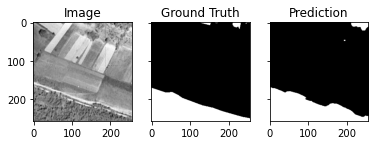

<Figure size 432x288 with 0 Axes>

Testing Epoch:  40%|███████████████████████████████████▌                                                     | 26/65 [00:07<00:11,  3.48it/s]

8


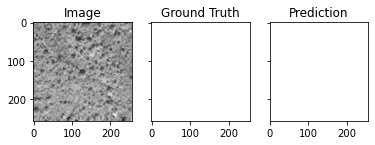

<Figure size 432x288 with 0 Axes>

Testing Epoch:  42%|████████████████████████████████████▉                                                    | 27/65 [00:07<00:10,  3.54it/s]

8


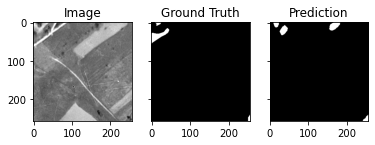

<Figure size 432x288 with 0 Axes>

Testing Epoch:  43%|██████████████████████████████████████▎                                                  | 28/65 [00:08<00:10,  3.55it/s]

8


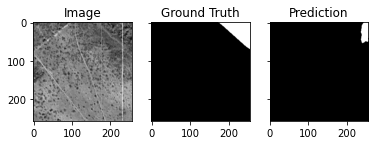

<Figure size 432x288 with 0 Axes>

Testing Epoch:  45%|███████████████████████████████████████▋                                                 | 29/65 [00:08<00:09,  3.70it/s]

8


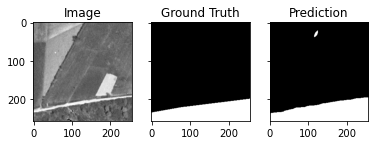

<Figure size 432x288 with 0 Axes>

Testing Epoch:  46%|█████████████████████████████████████████                                                | 30/65 [00:08<00:09,  3.80it/s]

8


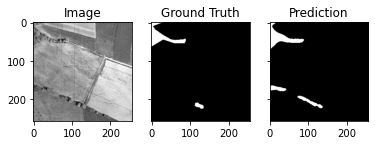

<Figure size 432x288 with 0 Axes>

Testing Epoch:  48%|██████████████████████████████████████████▍                                              | 31/65 [00:08<00:09,  3.75it/s]

8


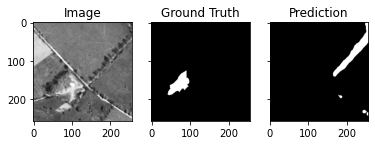

<Figure size 432x288 with 0 Axes>

Testing Epoch:  49%|███████████████████████████████████████████▊                                             | 32/65 [00:09<00:09,  3.54it/s]

8


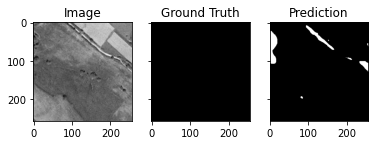

<Figure size 432x288 with 0 Axes>

Testing Epoch:  51%|█████████████████████████████████████████████▏                                           | 33/65 [00:09<00:08,  3.58it/s]

8


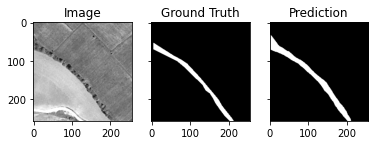

<Figure size 432x288 with 0 Axes>

Testing Epoch:  52%|██████████████████████████████████████████████▌                                          | 34/65 [00:09<00:08,  3.78it/s]

8


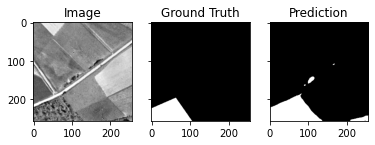

<Figure size 432x288 with 0 Axes>

Testing Epoch:  54%|███████████████████████████████████████████████▉                                         | 35/65 [00:10<00:07,  3.75it/s]

8


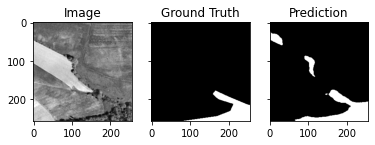

<Figure size 432x288 with 0 Axes>

Testing Epoch:  55%|█████████████████████████████████████████████████▎                                       | 36/65 [00:10<00:07,  3.71it/s]

8


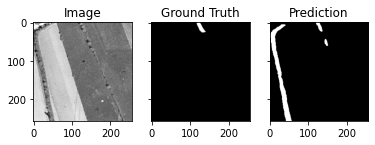

<Figure size 432x288 with 0 Axes>

Testing Epoch:  57%|██████████████████████████████████████████████████▋                                      | 37/65 [00:10<00:09,  3.02it/s]

8


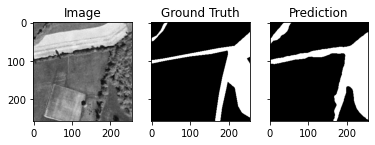

<Figure size 432x288 with 0 Axes>

Testing Epoch:  58%|████████████████████████████████████████████████████                                     | 38/65 [00:11<00:08,  3.26it/s]

8


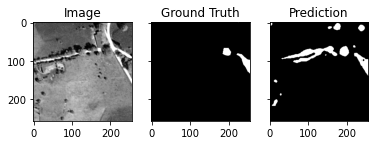

<Figure size 432x288 with 0 Axes>

Testing Epoch:  60%|█████████████████████████████████████████████████████▍                                   | 39/65 [00:11<00:07,  3.49it/s]

8


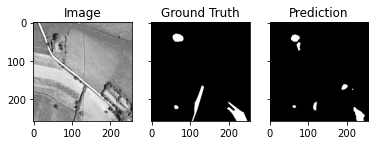

<Figure size 432x288 with 0 Axes>

Testing Epoch:  62%|██████████████████████████████████████████████████████▊                                  | 40/65 [00:11<00:06,  3.70it/s]

8


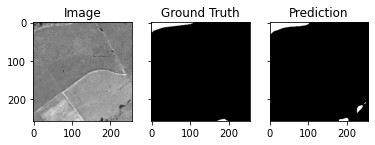

<Figure size 432x288 with 0 Axes>

Testing Epoch:  63%|████████████████████████████████████████████████████████▏                                | 41/65 [00:11<00:06,  3.87it/s]

8


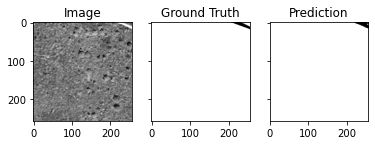

<Figure size 432x288 with 0 Axes>

Testing Epoch:  65%|█████████████████████████████████████████████████████████▌                               | 42/65 [00:11<00:05,  3.99it/s]

8


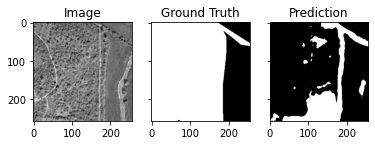

<Figure size 432x288 with 0 Axes>

Testing Epoch:  66%|██████████████████████████████████████████████████████████▉                              | 43/65 [00:12<00:05,  3.82it/s]

8


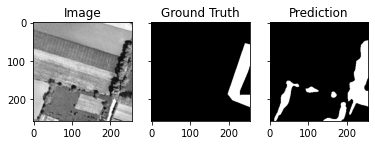

<Figure size 432x288 with 0 Axes>

Testing Epoch:  68%|████████████████████████████████████████████████████████████▏                            | 44/65 [00:12<00:05,  3.61it/s]

8


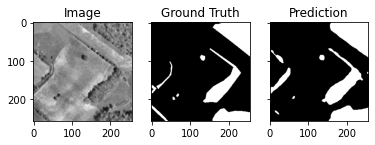

<Figure size 432x288 with 0 Axes>

Testing Epoch:  69%|█████████████████████████████████████████████████████████████▌                           | 45/65 [00:12<00:05,  3.66it/s]

8


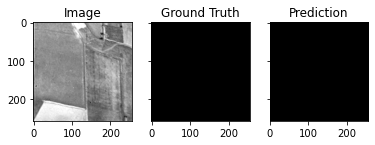

<Figure size 432x288 with 0 Axes>

Testing Epoch:  71%|██████████████████████████████████████████████████████████████▉                          | 46/65 [00:13<00:05,  3.66it/s]

8


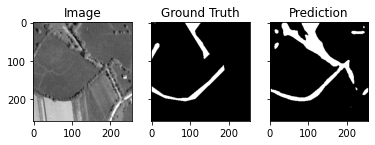

<Figure size 432x288 with 0 Axes>

Testing Epoch:  72%|████████████████████████████████████████████████████████████████▎                        | 47/65 [00:13<00:04,  3.80it/s]

8


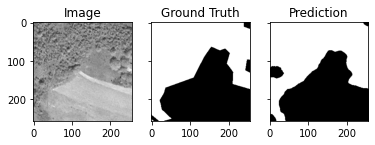

<Figure size 432x288 with 0 Axes>

Testing Epoch:  74%|█████████████████████████████████████████████████████████████████▋                       | 48/65 [00:13<00:04,  3.61it/s]

8


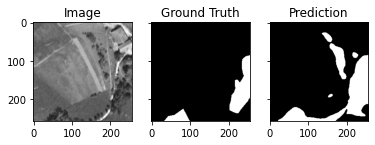

<Figure size 432x288 with 0 Axes>

Testing Epoch:  75%|███████████████████████████████████████████████████████████████████                      | 49/65 [00:13<00:04,  3.39it/s]

8


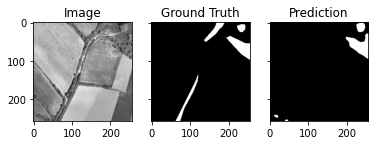

<Figure size 432x288 with 0 Axes>

Testing Epoch:  77%|████████████████████████████████████████████████████████████████████▍                    | 50/65 [00:14<00:05,  2.81it/s]

8


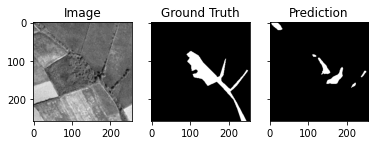

<Figure size 432x288 with 0 Axes>

Testing Epoch:  78%|█████████████████████████████████████████████████████████████████████▊                   | 51/65 [00:14<00:04,  2.99it/s]

8


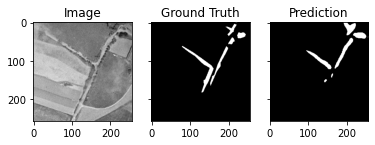

<Figure size 432x288 with 0 Axes>

Testing Epoch:  80%|███████████████████████████████████████████████████████████████████████▏                 | 52/65 [00:15<00:04,  3.13it/s]

8


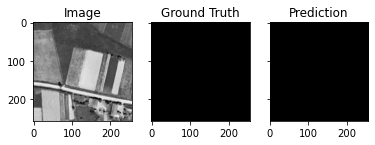

<Figure size 432x288 with 0 Axes>

Testing Epoch:  82%|████████████████████████████████████████████████████████████████████████▌                | 53/65 [00:15<00:03,  3.26it/s]

8


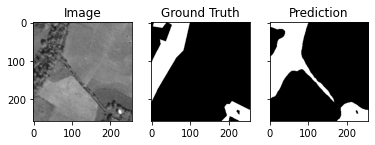

<Figure size 432x288 with 0 Axes>

Testing Epoch:  83%|█████████████████████████████████████████████████████████████████████████▉               | 54/65 [00:15<00:03,  3.33it/s]

8


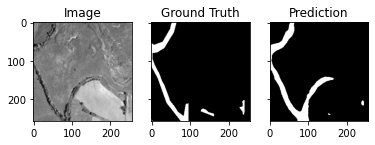

<Figure size 432x288 with 0 Axes>

Testing Epoch:  85%|███████████████████████████████████████████████████████████████████████████▎             | 55/65 [00:15<00:02,  3.43it/s]

8


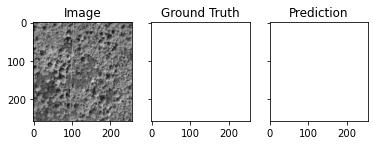

<Figure size 432x288 with 0 Axes>

Testing Epoch:  86%|████████████████████████████████████████████████████████████████████████████▋            | 56/65 [00:16<00:02,  3.32it/s]

8


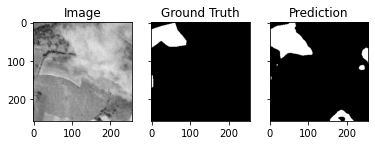

<Figure size 432x288 with 0 Axes>

Testing Epoch:  88%|██████████████████████████████████████████████████████████████████████████████           | 57/65 [00:16<00:02,  3.13it/s]

8


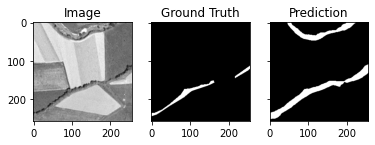

<Figure size 432x288 with 0 Axes>

Testing Epoch:  89%|███████████████████████████████████████████████████████████████████████████████▍         | 58/65 [00:16<00:02,  3.08it/s]

8


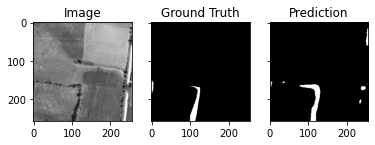

<Figure size 432x288 with 0 Axes>

Testing Epoch:  91%|████████████████████████████████████████████████████████████████████████████████▊        | 59/65 [00:17<00:01,  3.04it/s]

8


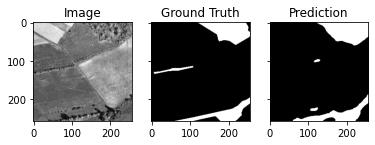

<Figure size 432x288 with 0 Axes>

Testing Epoch:  92%|██████████████████████████████████████████████████████████████████████████████████▏      | 60/65 [00:17<00:01,  2.99it/s]

8


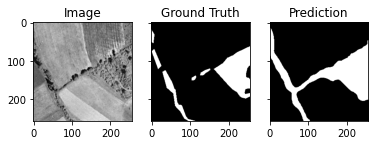

<Figure size 432x288 with 0 Axes>

Testing Epoch:  94%|███████████████████████████████████████████████████████████████████████████████████▌     | 61/65 [00:17<00:01,  3.00it/s]

8


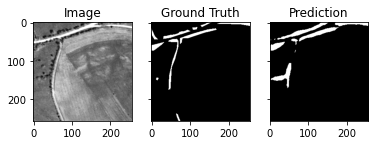

<Figure size 432x288 with 0 Axes>

Testing Epoch:  95%|████████████████████████████████████████████████████████████████████████████████████▉    | 62/65 [00:18<00:00,  3.23it/s]

8


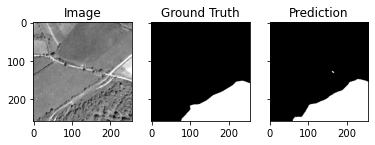

<Figure size 432x288 with 0 Axes>

Testing Epoch:  97%|██████████████████████████████████████████████████████████████████████████████████████▎  | 63/65 [00:18<00:00,  2.89it/s]

8


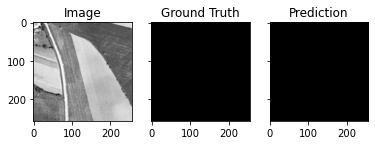

<Figure size 432x288 with 0 Axes>

Testing Epoch:  98%|███████████████████████████████████████████████████████████████████████████████████████▋ | 64/65 [00:18<00:00,  3.17it/s]

8


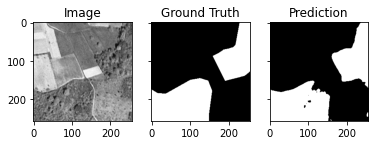

<Figure size 432x288 with 0 Axes>

In [17]:
# WandB – Initialize a new run
wandb.init(entity="vibferreira", project="master_thesis")

# set the model in evaluation model
BEST_MODEL = '../best_model'
best_iou_model = glob.glob(BEST_MODEL + '/*.pth')[0]
folder = '../saved_images'

# load the model 
model_ = model.unet_model.to(config.DEVICE)
model_.load_state_dict(torch.load(best_iou_model))

hat, true = make_predictions(model_, test_dataloader)

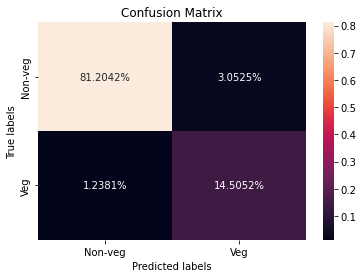

              precision    recall  f1-score   support

     Non-veg       0.98      0.96      0.97  28713599
         Veg       0.83      0.92      0.87   5365121

    accuracy                           0.96  34078720
   macro avg       0.91      0.94      0.92  34078720
weighted avg       0.96      0.96      0.96  34078720



In [18]:
metrics.cm_and_class_report(hat, true)

In [19]:
# model.unet_model